![title](yelp2.jpg)
# Smash the Snorkel Team Project: 
# A Weak Supervised Learning Study for Yelp Restaruant Review Classification 


## 1. Introduction

## 1.1 Business Problem Identification

The competition between restaurants is fiercer than ever. Restaurant owners are under consistent pressure 
to improve their business or set themselves apart from the rest. But how? Although some restuarants still rely 
on asking their customers directly, more and more restuarants have been leveraging reviews on apps like Yelp 
to understand what their customers need. In this case, the reviews containing complaints/suggestions are invaluable as they 
explicitly point out the possible solution to improving customers' satisfaction.

For restuarants receiving numerous reviews,however, it is hard for the business owners to investigate every review to figure 
out whether the reviews contain useful suggestions/complaints. Therefore, an automatic process is needed to filter irrelevent 
information quickly.

## 1.2 Project Objective

In this project we seek to automize the classification of reviews to understand whether a review is mentioning complaints or suggestions using **Yelp** review dataset. One extra challenge that lies ahead is that we don't have any datapoint with the "golden" label indicating this piece of  information. 
Consequently, to cope with this problem, we aim to find solution to classification problem without any existing labels.

**Objective**: Find solution for classification problem when there is no pre-exsiting label.

## 1.3 Key Results

There are four major results in this project.
a) Build a Database hosting the data source to mimic the industrial canon.
b) Create labeling functions using Snorkel DryBell to provide weak supervised-learning at industrial scale.
c) Augment dataset to create more training datapoints
d) Train a classifier for labeling a unseen review automatically. 

## 1.4 Project Structure

Below you can see a diagram that represents the workflow of the project. This includes the flow of the original files from start to end, and the actions taken in each step of the process. <br><br>
As you can see we have acquired flat files in JSON format from the official yelp website. Then we have uploaded on of the files on the CosmosDB platform of Microsoft Azure in the MongoDB database that we have created. Due to the size of the files and the resource restrictions, we were not able to upload all of them. The flat files were then parsed into csv format in order to manipulate them as spark dataframes and we moved on to use the reviews dataframe as the basis of our analysis. This was split into 3 sets: <br>
- The <b>development set</b> (500 rows) that was manually labeled and used to perform data understanding, analysis, aggregations feature engineering. This process also involved fetching the file from the MongoDB database to extract information. Then with this set we have created and evaluated the labeling functions. This whole process was iterative, as with each iteration we were imporoving the construction of the labeling functions.<br>
-  The <b>train set</b> containing vast amount of data points was sampled to be able to apply efficiently the previously created labeling functions. This resulted to having a weakly labeled train set that was then augmented using data augmentation techniques like transformation functions. The output of this was the train set that we fit our classifiers in order to come to a final prediction.<br>
- The <b>test set</b> (500 rows) that was manually labeled and used to validate and tune the classifiers.

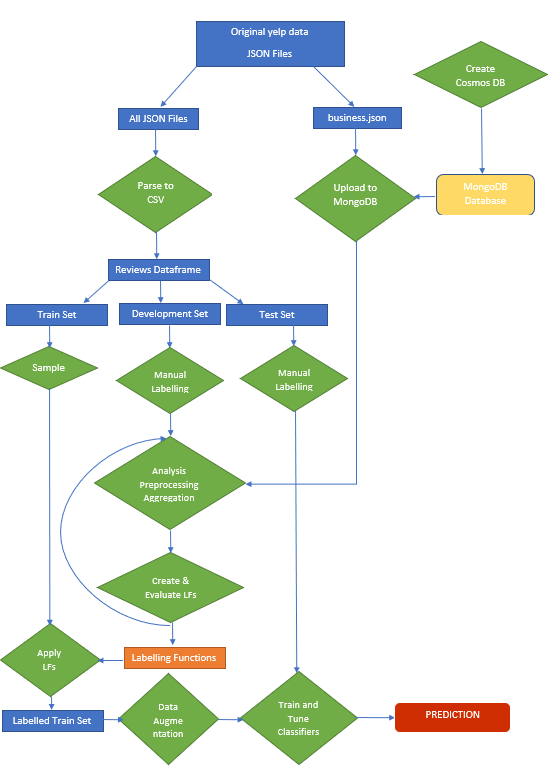

In [1]:
from IPython.display import Image
Image("Diagram.PNG")

## 2. Loading Data

In [1]:
# Set up Pyspark dependencies
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

### 2.1 Data Source 1: Mongo DB

[To be continue:]

### 2.2 Data Source 2: Local JSON Files

Due to the limit of database resource, we import other datasources from local json files. 

The json file is a no-relational data storage format, therefore, before we can analyse our data we need to parse it into a more understandable format. 
Besides, some of the json files are quite large and hence loading them with pandas is going to be slow and make the local machine 
run out of memory easily. Accordingly, we utilise Pyspark to accelerate the computation.      

### 2.3 Data Filtering

In [2]:
#First:  restaurant
biz_df = sqlContext.read.json("original_data/business.json") # Mongo Needed
biz_df.createOrReplaceTempView('biz_table')
#only keep restaurants
biz_res = sqlContext.sql('SELECT * FROM biz_table WHERE categories LIKE \'%Restaurants%\'') # Mongo Needed
biz_res.createOrReplaceTempView('biz_res_table')

def filter_res(parent,filename,key): #filter the irrelevant records from other table
    df = sqlContext.read.json("original_data/"+filename)
    table_name=filename[:-5]+'_table'
    df.createOrReplaceTempView(filename[:-5]+'_table')
    sqlquery = 'SELECT c.* FROM {} c LEFT JOIN {} b ON c.{} = b.{} WHERE b.{} IS NOT NULL'.format(table_name,parent,key,key,key)
    print(sqlquery)
    df_res=sqlContext.sql(sqlquery)
    return df_res

checkin_res = filter_res('biz_res_table','checkin.json','business_id')
review_res = filter_res('biz_res_table','review.json','business_id')
review_res.createOrReplaceTempView('review_res_table')
tip_res = filter_res('review_res_table','tip.json','user_id') #since tip is on individual level, match them with users
user_res = filter_res('review_res_table','user.json','user_id')


SELECT c.* FROM checkin_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM review_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM tip_table c LEFT JOIN review_res_table b ON c.user_id = b.user_id WHERE b.user_id IS NOT NULL
SELECT c.* FROM user_table c LEFT JOIN review_res_table b ON c.user_id = b.user_id WHERE b.user_id IS NOT NULL


As we focus our classification task on the reviews for the restaurant, here we first filter the 'business' table to 
keep only the restaurants and based on this table we filter out the records in other table that is irrelevent to restarurants.


### 2.4 Data Spliting

In [3]:
#sample business into traning_set dev_set and test_set
import pyspark.sql.functions as f
review_res = review_res.withColumn('index_1', f.monotonically_increasing_id())
review_res.createOrReplaceTempView('review_res_table')
sqlquery = 'SELECT * FROM review_res_table ORDER BY RAND(42) LIMIT {}'.format(1000)
review_sample = sqlContext.sql(sqlquery)
review_sample.createOrReplaceTempView('review_sample_table')

sqlquery = 'SELECT a.* FROM review_res_table a LEFT JOIN review_sample_table b ON a.index_1 = b.index_1 WHERE b.index_1 IS NULL '
review_train_all = sqlContext.sql(sqlquery)

#sample 500 into dev_set and 500 into test_set
from pyspark.sql.functions import desc
review_sample = review_sample.withColumn('index_2', f.monotonically_increasing_id())
review_dev = review_sample.limit(500)
review_test = review_sample.sort(desc("index_2")).limit(500)

In [4]:
# sampling from original training_set since it is too large for our single machine to apply the LFs
review_train_all.createOrReplaceTempView('review_train_all_table')
sqlquery = 'SELECT * FROM review_train_all_table ORDER BY RAND(42) LIMIT {}'.format(2500)
review_train = sqlContext.sql(sqlquery)

In [26]:
review_train.toPandas().to_csv('review_train_final.csv')

In [5]:
review_dev.toPandas().to_csv('filtered_data/review_dev.csv',header = 'true') #tospark
review_test.toPandas().to_csv('filtered_data/review_test.csv',header = 'true') #tospark

Preparing for the development of labeling fuctions and the training of classifier, we split the filtered review data
into three parts, namely training set, testing set and development set. We first randomly sample 1000 reviews out of all
resturant reviews, and split the first 500 into development set and the rest into testing set. As we don't have labels at all,
we will manually label the reviews in development and testing sets with 1 standing for suggestions/complaints and 0 for the rest.

In addition, considering the computing resources we have it is not feasible for us to apply the labeling functions to all of the remaining
6 million reviews. As a result, we sample 2500 reviews out of the "complete" training set focusing on demonstrating how the whole process may work 
when more computing resources are available.

## 3. Labeling Functions

### 3.1 Manual Labeling

[To be continue:]

### 3.2 Writing Labeling Functions 1: Text-based Functions

[To be continue:]

In [6]:
#Shuo's Part:

In [ ]:
#Pavlos's Part:

In [ ]:
#Simon's Part:

### 3.2 Writing Labeling Functions 2: Numerical Functions

[To be continue:]

In [11]:
#Jiaqi's Part
# aggregate the mean star each business and individual
df_biz_stars=biz_res.select('business_id','stars','review_count') # aggregate business
ind_stars=review_res.select('user_id','stars','business_id') #aggregate ind
mapped_test = ind_stars.rdd.map(lambda x: (x[0],x[1]))
ind_total_starts = mapped_test.reduceByKey(lambda a,b:a+b)
mapped_test = ind_stars.rdd.map(lambda x: (x[0],1))
ind_total_review =  mapped_test.reduceByKey(lambda a,b:a+b)

# convert to spark data frame
df_ind_total_starts = ind_total_starts.toDF(["user_id", "total_stars"])
df_ind_total_review = ind_total_review.toDF(["user_id", "total_reviews"])
df_ind_stars = df_ind_total_starts.join(df_ind_total_review, df_ind_total_starts.user_id == df_ind_total_review.user_id)
df_ind_stars = df_ind_stars.withColumn('avg_stars' , df_ind_stars.total_stars/df_ind_stars.total_reviews)
df_ind_stars.show()
df_biz_stars.show()

df_biz_stars=df_biz_stars.toPandas()
df_ind_stars=df_ind_stars.toPandas()
df_ind_stars = df_ind_stars.loc[:,~df_ind_stars.columns.duplicated()]

import pandas as pd
from pyspark.sql import SparkSession
from snorkel.labeling import PandasLFApplier,LFAnalysis
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()
pd_dev = pd.read_csv("review_dev_labelled.csv",header=0, index_col=0)
df_dev = spark.createDataFrame(pd_dev)


+--------------------+-----------+--------------------+-------------+------------------+
|             user_id|total_stars|             user_id|total_reviews|         avg_stars|
+--------------------+-----------+--------------------+-------------+------------------+
|-0Ji0nOyFe-4yo8BK...|        4.0|-0Ji0nOyFe-4yo8BK...|            1|               4.0|
|-1KKYzibGPyUX-Mwk...|        4.0|-1KKYzibGPyUX-Mwk...|            1|               4.0|
|-1zQA2f_syMAdA04P...|       10.0|-1zQA2f_syMAdA04P...|            2|               5.0|
|-2Pb5d2WBPtbyGT_b...|        5.0|-2Pb5d2WBPtbyGT_b...|            1|               5.0|
|-3bsS2i9xqjNnIA1f...|        5.0|-3bsS2i9xqjNnIA1f...|            2|               2.5|
|-3i9bhfvrM3F1wsC9...|       34.0|-3i9bhfvrM3F1wsC9...|            9|3.7777777777777777|
|-47g7LR58tpHlm7Bm...|        5.0|-47g7LR58tpHlm7Bm...|            1|               5.0|
|-4Anvj46CWf57KWI9...|        3.0|-4Anvj46CWf57KWI9...|            1|               3.0|
|-4xyc3OgPwrLshmqH...

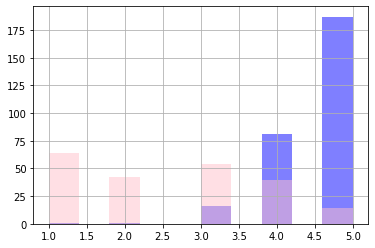

In [18]:
#Threshold Analysis: Pure Stars
temp=pd_dev  
temp[temp['label']==0]['stars'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['stars'].hist(bins=10,color='pink',alpha=0.5);

As shown in the threshold analysis here, it is understood that if reviews have a star lower than 2, it is very likely to
contain complaint/suggestion. And for those whose star is higher than five, it is probably a review without complaints/suggestion. Therefore, we create two labeling functions based on 
this observation.

In [26]:

import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

@labeling_function()
def low_star(x):
    return POSITIVE if x.stars<=2 else ABSTAIN


@labeling_function()
def high_star(x):
    return NEGATIVE if x.stars==5 else ABSTAIN






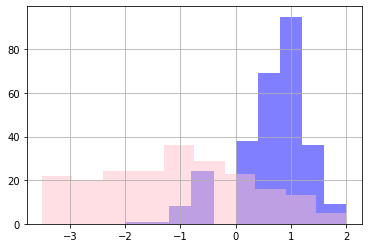

In [20]:
#Threshold Analysis: Higher or lower than business average
temp=pd_dev.merge(df_biz_stars, on= 'business_id', how='left')
temp['dif']= temp['stars_x']-temp['stars_y']
temp[temp['label']==0]['dif'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['dif'].hist(bins=10,color='pink',alpha=0.5);

The graph shows that if the review star is more than one star lower than the business star, then it's very likely 
than the review should be label as 1 whereas if it is higher than the business star, it is probably a review without
complaints or suggestions.

In [52]:
dict_biz_stars = dict(zip(df_biz_stars.business_id, df_biz_stars.stars))

@labeling_function(resources=dict(dict_biz_stars=dict_biz_stars))
def higher_than_biz(x,dict_biz_stars):
    if x.business_id!='#NAME?':
        a = dict_biz_stars[x.business_id]
    else:
        a = 0
    return NEGATIVE if a<x.stars  else ABSTAIN

@labeling_function(resources=dict(dict_biz_stars=dict_biz_stars))
def lower_than_biz(x,dict_biz_stars):
    if x.business_id!='#NAME?':
        a = dict_biz_stars[x.business_id]
    else:
        a = 0
    return POSITIVE if a>x.stars+1  else ABSTAIN

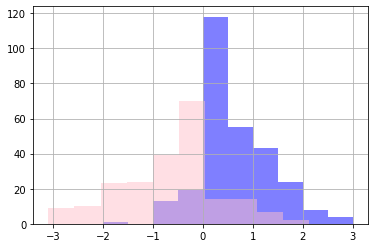

In [28]:
#Threshold Analysis: higher or lower than individual average
temp=pd_dev.merge(df_ind_stars, on= 'user_id', how='left')
temp['dif']= temp['stars']-temp['avg_stars']
temp[temp['label']==0]['dif'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['dif'].hist(bins=10,color='pink',alpha=0.5);

The graph shows that if the review star is lower than the average user star, then it's very likely 
than the review should be label as 1 whereas if it is higher, it is probably a review without
complaints or suggestions.

In [54]:
com_info = zip(df_ind_stars.avg_stars, df_ind_stars.total_reviews)
dict_ind_stars = dict(zip(df_ind_stars.user_id, com_info ))
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def higher_than_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return NEGATIVE if (x.stars > a) else ABSTAIN

@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def lower_than_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return POSITIVE if (x.stars < a) else ABSTAIN

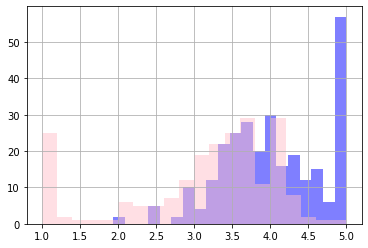

In [38]:
#Threshold Analysis: Picky individual
temp[temp['label']==0]['avg_stars'].hist(bins=20,color='blue',alpha=0.5);
temp[temp['label']==1]['avg_stars'].hist(bins=20,color='pink',alpha=0.5);

The graph shows that if the average review star is lower than 4.25, the review is more likely to be a complaint or suggestion.

In [44]:
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def picky_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return POSITIVE if a <4.25 else ABSTAIN

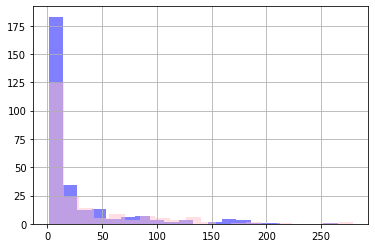

In [46]:
#Threshold Analysis: Talktive individual
temp[(temp['label']==0) & (temp['total_reviews']<300)]['total_reviews'].hist(bins=20,color='blue',alpha=0.5);
temp[(temp['label']==1)& (temp['total_reviews']<300)]['total_reviews'].hist(bins=20,color='pink',alpha=0.5);

In [47]:
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def talktive_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            b = dict_ind_stars[x.user_id][1]
        else:
            b = 0 
    else:
        b = 0
    return POSITIVE if b > 86  else ABSTAIN

In [48]:
#merge user_dev.jointime 
reduced_user = user_res.select('user_id','yelping_since')
reduced_user_pd= reduced_user.toPandas().drop_duplicates(subset=['user_id'])
reduced_user_pd['date']=reduced_user_pd['yelping_since'].map(lambda x:int(x[0:4]))
temp=pd_dev.merge(reduced_user_pd, on= 'user_id', how='left')


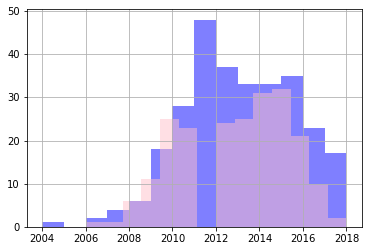

In [49]:
temp[temp['label']==0]['date_y'].hist(bins=14,color='blue',alpha=0.5);
temp[temp['label']==1]['date_y'].hist(bins=14,color='pink',alpha=0.5);

The graph shows that if the join year is 2011 or after 2016, the review is less likely to be a complaint or suggestion.

In [50]:
dict_user_date = dict(zip(reduced_user_pd.user_id, reduced_user_pd.date))
@labeling_function(resources=dict(dict_user_date=dict_user_date))
def date_ind(x,dict_user_date):
    if x.user_id!='#NAME?':
        if x.user_id in dict_user_date.keys():
            b = dict_user_date[x.user_id]
        else:
            b = 3000 
    else:
        b = 3000
    return NEGATIVE if (b==2011 or b>=2016)  else ABSTAIN

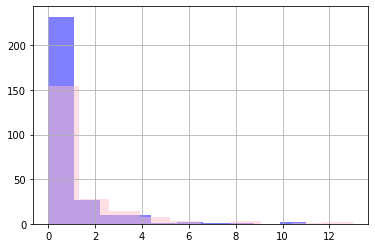

In [58]:
#Threshold Analysis: userful counts
temp=pd_dev.merge(df_ind_stars, on= 'user_id', how='left')
temp[(temp['label']==0) & (temp['useful']<=20)]['useful'].hist(bins=10,color='blue',alpha=0.5);
temp[(temp['label']==1) & (temp['useful']<=20)]['useful'].hist(bins=10,color='pink',alpha=0.5);

In [55]:
# Build label matrix
lfs = [low_star,high_star,higher_than_biz,lower_than_biz,higher_than_ind,lower_than_ind,picky_ind,talktive_ind,date_ind]
applier = SparkLFApplier(lfs)
L_dev = applier.apply(df_dev.rdd)
g_label =np.array(df_dev.select('label').collect())
LFAnalysis(L_dev, lfs).lf_summary(g_label) 

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
low_star,0,[1],0.216,0.216,0.064,106,2,0.981481
high_star,1,[0],0.402,0.400,0.210,187,14,0.930348
higher_than_biz,2,[0],0.500,0.500,0.314,214,36,0.856000
lower_than_biz,3,[1],0.184,0.184,0.050,90,2,0.978261
higher_than_ind,4,[0],0.456,0.456,0.378,187,41,0.820175
lower_than_ind,5,[1],0.328,0.314,0.110,131,33,0.798780
picky_ind,6,[1],0.766,0.744,0.500,204,179,0.532637
talktive_ind,7,[1],0.120,0.120,0.088,31,29,0.516667
date_ind,8,[0],0.294,0.294,0.226,89,58,0.605442


## 4. Data Augmentation

[To be continue:]

In [7]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
#!pip install utils-py
! python -m spacy download en_core_web_sm
import nltk
from nltk.corpus import wordnet as wn
from snorkel.augmentation import transformation_function
import spacy
from snorkel.preprocess.nlp import SpacyPreprocessor
import en_core_web_sm
nlp = en_core_web_sm.load()
spacy.load('en_core_web_sm')
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)
from snorkel.augmentation import RandomPolicy
nltk.download("wordnet")

     |████████████████████████████████| 12.0 MB 732 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011738 sha256=e4e4faf71a74c31f3783f87064b9e89ee552e1d9e1872ea1f603f79f2d8f879d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2bl72npf/wheels/b5/94/56/596daa677d7e91038cbddfcf32b591d0c915a1b3a3e3d3c79d
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package wordnet to /home/faculty/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
#Define TFs

def get_synonym(word, pos=None):
    """Get synonym for word given its part-of-speech (pos)."""
    synsets = wn.synsets(word, pos=pos)
    # Return None if wordnet has no synsets (synonym sets) for this word and pos.
    if synsets:
        words = [lemma.name() for lemma in synsets[0].lemmas()]
        if words[0].lower() != word.lower():  # Skip if synonym is same as word.
            # Multi word synonyms in wordnet use '_' as a separator e.g. reckon_with. Replace it with space.
            return words[0].replace("_", " ")
        
def replace_token(spacy_doc, idx, replacement):
    """Replace token in position idx with replacement."""
    return " ".join([spacy_doc[:idx].text, replacement, spacy_doc[1 + idx :].text])

@transformation_function(pre=[spacy])
def replace_verb_with_synonym(x):
    # Get indices of verb tokens in sentence.
    verb_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "VERB"]
    if verb_idxs:
        # Pick random verb idx to replace.
        idx = np.random.choice(verb_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="v")
        # If there's a valid verb synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x
        
@transformation_function(pre=[spacy])
def replace_noun_with_synonym(x):
    # Get indices of noun tokens in sentence.
    noun_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "NOUN"]
    if noun_idxs:
        # Pick random noun idx to replace.
        idx = np.random.choice(noun_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="n")
        # If there's a valid noun synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x


@transformation_function(pre=[spacy])
def replace_adjective_with_synonym(x):
    # Get indices of adjective tokens in sentence.
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    if adjective_idxs:
        # Pick random adjective idx to replace.
        idx = np.random.choice(adjective_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="a")
        # If there's a valid adjective synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x
@transformation_function(pre=[spacy])      
def swap_adjectives(x):
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    # Check that there are at least two adjectives to swap.
    if len(adjective_idxs) >= 2:
        idx1, idx2 = sorted(np.random.choice(adjective_idxs, 2, replace=False))
        # Swap tokens in positions idx1 and idx2.
        x.text = " ".join(
            [
                x.doc[:idx1].text,
                x.doc[idx2].text,
                x.doc[1 + idx1 : idx2].text,
                x.doc[idx1].text,
                x.doc[1 + idx2 :].text,
            ]
        )
        return x
    
tfs = [replace_verb_with_synonym,
       replace_noun_with_synonym,
       replace_adjective_with_synonym,
       swap_adjectives]

In [21]:
from snorkel.augmentation import ApplyOnePolicy

random_policy = ApplyOnePolicy(
    n_per_original=2, keep_original=True
)

In [25]:
import numpy as np
from snorkel.augmentation import PandasTFApplier
tf_applier = PandasTFApplier(tfs,random_policy)

# Apply the TFs on the train set
df_train_augmented = tf_applier.apply(pd_dev)
Y_train_augmented = df_train_augmented["label"].values

print(f"Original training set size: {pd_dev.shape}")
print(f"Augmented training set size: {df_train_augmented.shape}")

100%|██████████| 500/500 [00:00<00:00, 815.43it/s]

Original training set size: (500, 12)
Augmented training set size: (1088, 12)


In [24]:

#df_train_augmented.review_id.value_counts()

#NAME?                    23
NsZGlPXFdGR81QgAM-1dLA     3
m9r8hyJa6FYvhupkS7FtzQ     3
bItLXmQe0PAPPyL-IkElvg     3
d-pUL8f4r8nBXI9YiXFGVg     3
                          ..
O2MZtWGujBiU7SPA66J2VA     1
CMN4n4uUNr73Q1Utj8p6-A     1
dqC9nWK-5NCe61CgmzOW0w     1
lR77vG8K4rRd69K_UBTA-g     1
_MBtHf2T0HCzwwmzac4z2Q     1
Name: review_id, Length: 491, dtype: int64

In [ ]:

query = 'select t.site, t.year, g.month, t.sales / 12 from the_table tcross join generate_series(1,12) as g (month)
order by  t.site, t.year, g.month;

In [18]:
from pyspark.sql.functions import udf, explode
from pyspark.sql.types import ArrayType, IntegerType

df = spark.createDataFrame([(1,2,1), (2,9,1), (3,8,2), (4,1,1), (5,3,3)] ,["A", "B", "n"]) 

# use udf function to transform the n value to n times
n_to_array = udf(lambda n : [n] * n, ArrayType(IntegerType()))
df2 = df.withColumn('n', n_to_array(df.n))
df2.show()
# now use explode  
df2.withColumn('n', explode(df2.n)).show()

+---+---+---------+
|  A|  B|        n|
+---+---+---------+
|  1|  2|      [1]|
|  2|  9|      [1]|
|  3|  8|   [2, 2]|
|  4|  1|      [1]|
|  5|  3|[3, 3, 3]|
+---+---+---------+

+---+---+---+
|  A|  B|  n|
+---+---+---+
|  1|  2|  1|
|  2|  9|  1|
|  3|  8|  2|
|  3|  8|  2|
|  4|  1|  1|
|  5|  3|  3|
|  5|  3|  3|
|  5|  3|  3|
+---+---+---+



## 5. Training the Binary Classifier 

[To be continue:]

## 6. Conclusions

## 6.1 Summary

Through Section 2 to Section 5, we have demonstrated a complete pipeline for a weak supervised learning project, including data extraction (loading data), data transformation (filtering, etc), mannual labeling, create labeling function, data augmentation and train classifers (within each another round of data transformation is done). Throughout the steps, we sought to apply scalable tools which makes it transferable to an industrial scale. 

By applying the various labeling functions ranging from NLP-based functions to numeric-based functions and data augmentation to the unlabeled dataset, we obtained the weak label for each datapoint and make more training data available for the classifier. In our case, by this method, we **continue** after seeing the result. 

## 6.2 Limitations

1. The major limitation of our work is resource and most significant example is that because the limited resource we can't host all of our json files on the NoSQL database that we created. 
2. XXXX


## 6.3 Further Work